In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

from utils import TestClassifier

%matplotlib inline
%load_ext autoreload
%autoreload 2

# 1. EDA

In [2]:
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')

In [3]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [4]:
df.shape

(299, 13)

In [5]:
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [6]:
# check if there are any missing values
df.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

There are now missing values in the dataset

In [7]:
# time column already seems useless for our purposes
df.drop('time', axis=1, inplace=True)
#change age d-type to int64
df = df.astype({'age': 'int64'})

## 1.1 Some basic visualizations

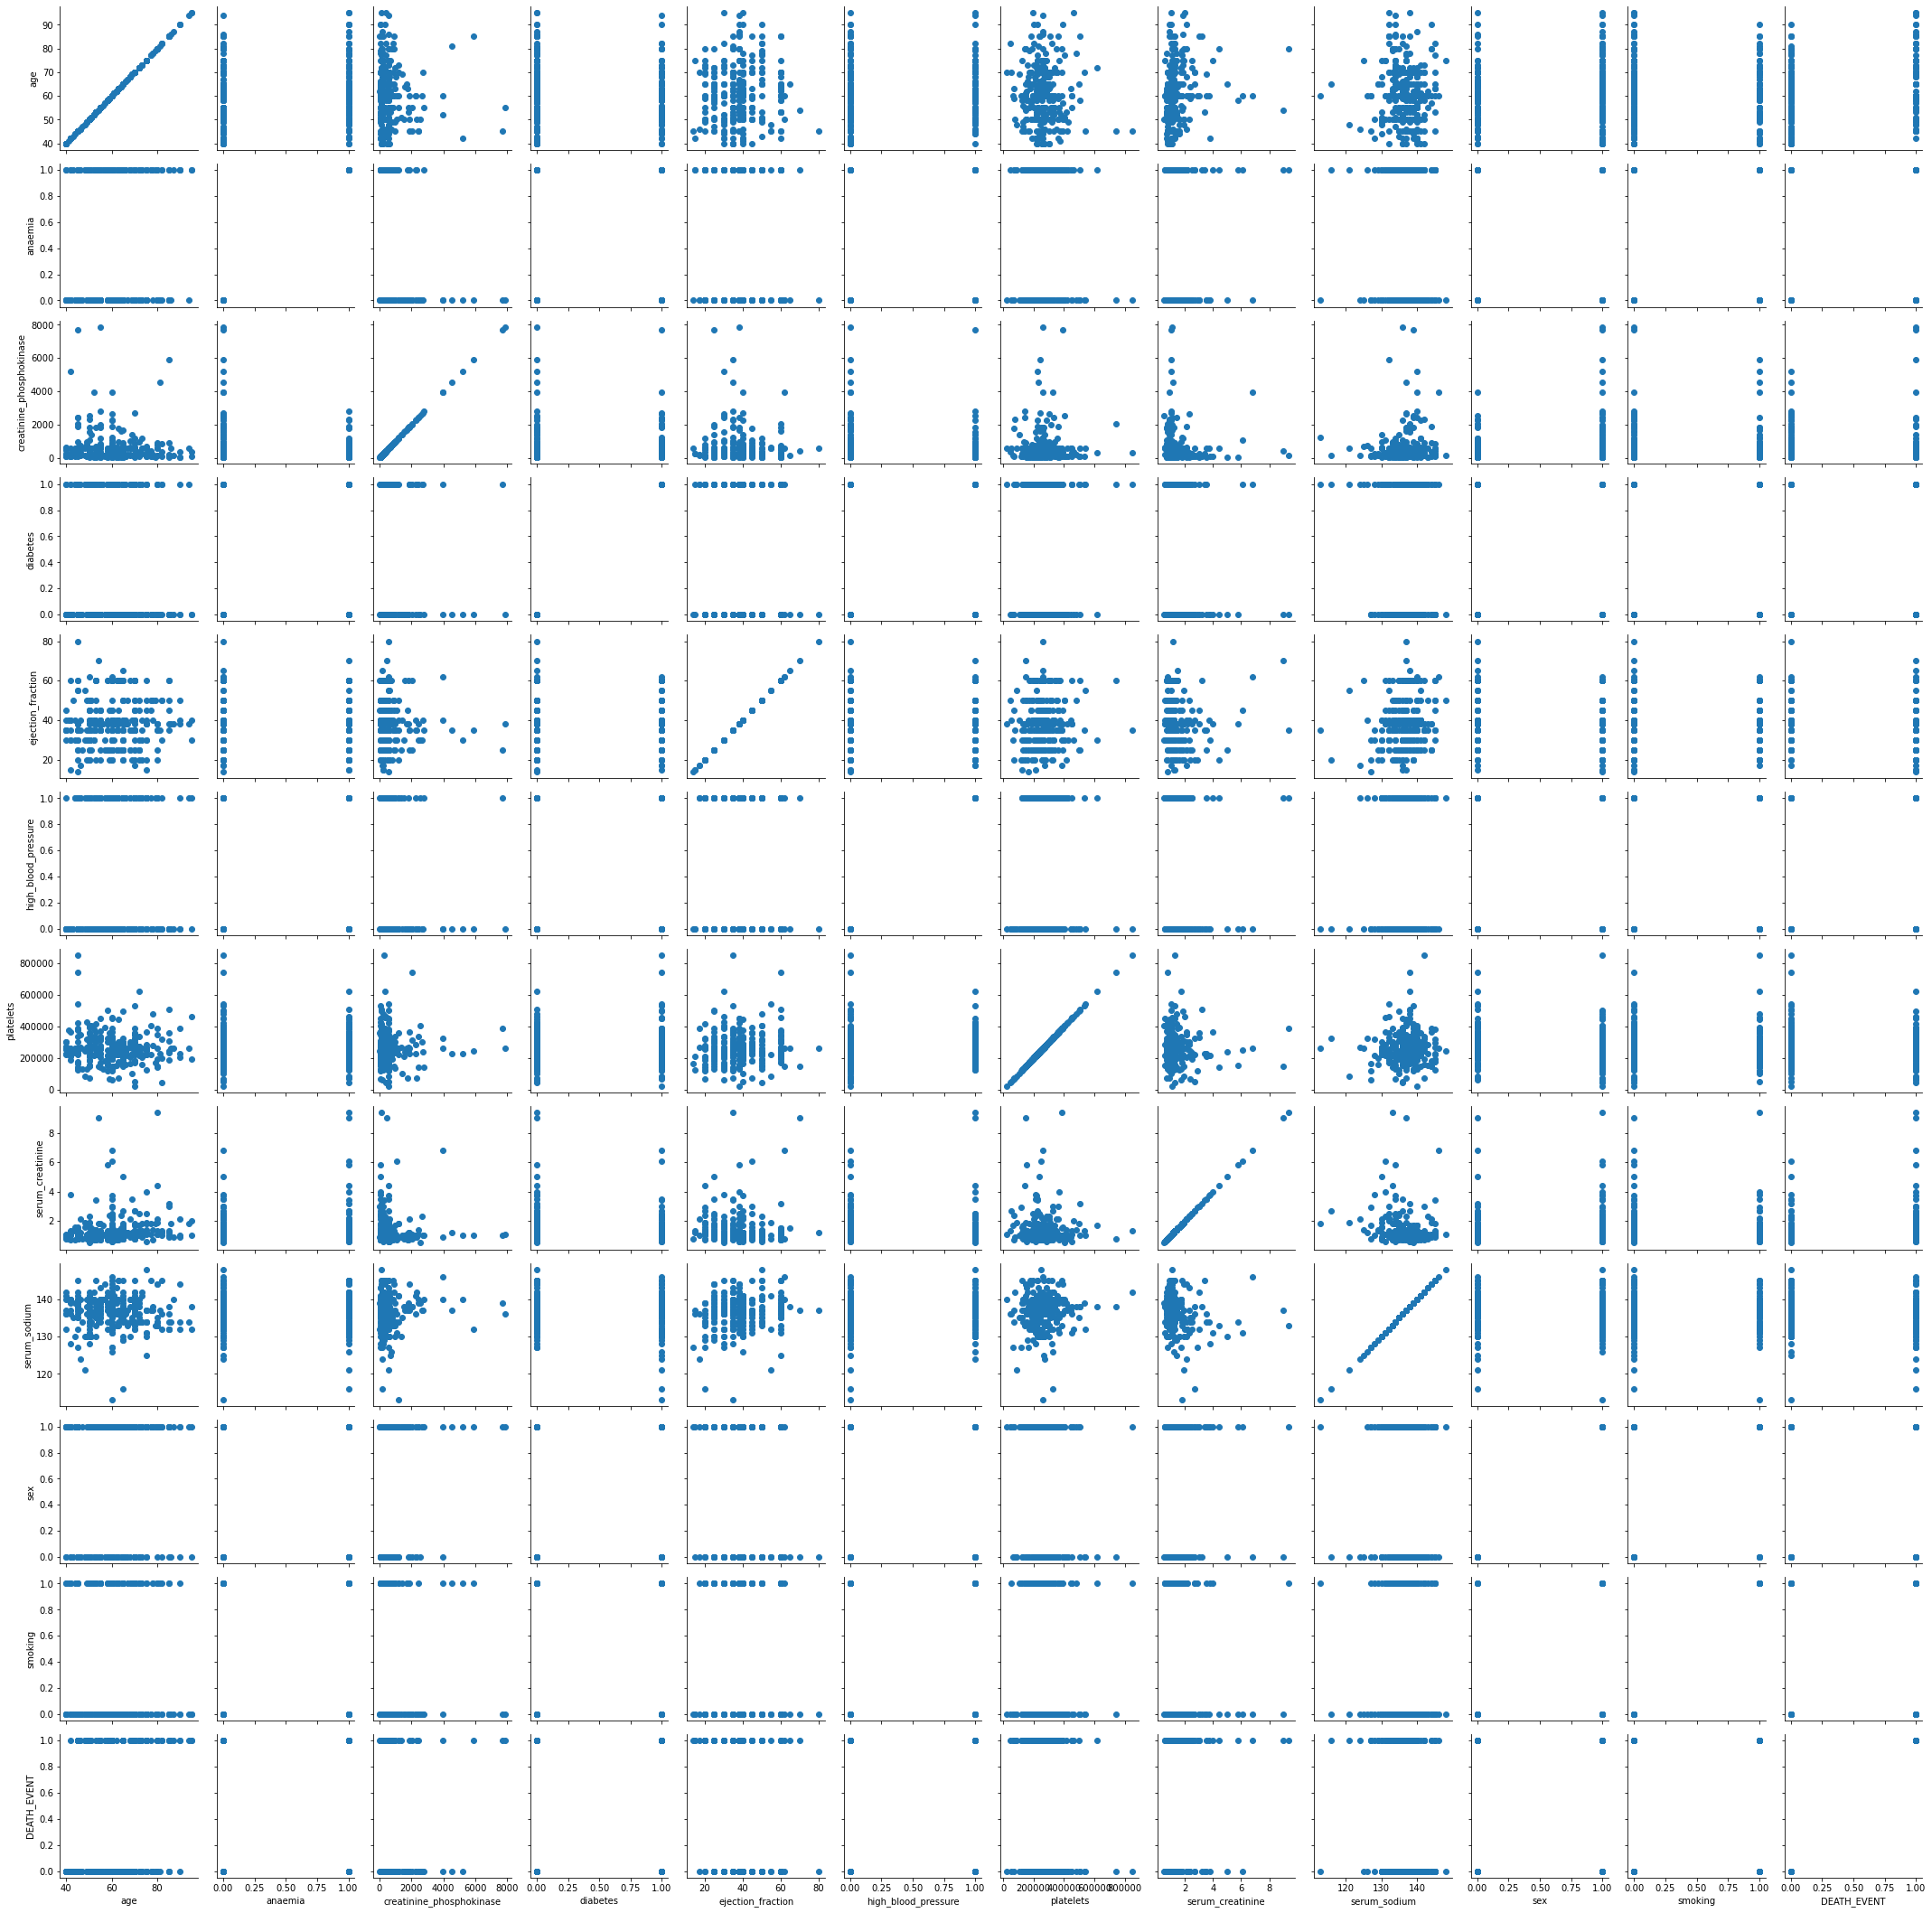

In [8]:
#lets start with some general info
sns.PairGrid(df).map(plt.scatter) ;

Nothing special out there, no obvious correlations.

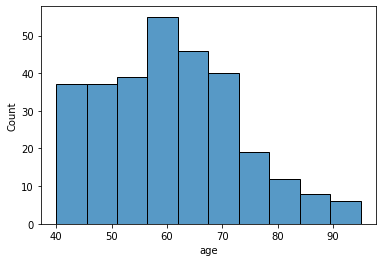

In [9]:
# visualise the age distribution
sns.histplot(df.age) ;

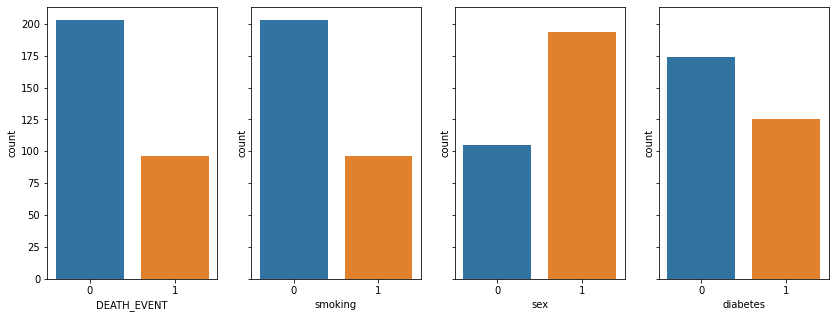

In [10]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize= (14, 5), sharey=True)
# how many people survived and deceased
sns.countplot(x='DEATH_EVENT', data=df, ax=ax1)
# how many people smokes
sns.countplot(x='smoking', data=df, ax=ax2) 
# how many women and men
sns.countplot(x='sex', data=df, ax=ax3)
# how many people have diabetes
sns.countplot(x='diabetes', data=df, ax=ax4) ;

## 1.2 Correlations and Tests

### Shapiro-Wilk test

First we will do the Shapiro-Wilk test for normality.
Based on the plots we have, we already can say that most likely the distribution of our features is not Gaussian.
But let's prove it with some statistic

H0 = sample is from Gaussian distribution

H1 != Gaussian distribution

In [12]:
p_values = {}
for column in df.columns:
    res = stats.shapiro(df[column])
    p_values.update({res.pvalue: column})

for p_value, column in sorted(p_values.items()):
    print(f'{column}\tp = {p_value}')

creatinine_phosphokinase	p = 7.050336006853421e-28
serum_creatinine	p = 5.3927583038658e-27
DEATH_EVENT	p = 4.5818434207772147e-26
sex	p = 1.1685004623776566e-25
high_blood_pressure	p = 1.1686175589182754e-25
diabetes	p = 5.115523846896366e-25
anaemia	p = 6.2099638288205785e-25
platelets	p = 2.8837446753443574e-12
serum_sodium	p = 9.210247564617191e-10
ejection_fraction	p = 7.215433139862171e-09
age	p = 5.1159073336748406e-05


As we can see, all p values are very low, means that we can reject our H0

So it means we need to work with nonparametric statistical methods (as expected)

Let's try some

### Mann-Whitney U test

First that obviously comes to mid is the Mann-Whitney U test.
We will test distribution of each feature, divided into 2 groups by 'DEATH_EVENT'.

H0 = distributions are the same.
H1 = distributions are not the same

In [29]:
p_values = {}
features = []
for column in df.columns:
    if column != 'DEATH_EVENT':
        survived = df.loc[df['DEATH_EVENT'] == 0, column].values
        dead = df.loc[df['DEATH_EVENT'] == 1, column].values
        res = stats.mannwhitneyu(survived, dead)
        p_values.update({res.pvalue: column})

for p_value, column in sorted(p_values.items()):
    if p_value <= 0.05:
        features.append(column)
    print(f'{column}\tp = {p_value}')
print('--------------------------')
print('Features that have p-value < 0.05 --> ', features)

serum_creatinine	p = 7.904989505917019e-11
ejection_fraction	p = 3.684124584238869e-07
age	p = 8.490199835613056e-05
serum_sodium	p = 0.00014637787318887364
high_blood_pressure	p = 0.08550819985739311
anaemia	p = 0.1264852041552424
platelets	p = 0.2127792549023304
creatinine_phosphokinase	p = 0.3420200130720179
smoking	p = 0.4140949800156031
sex	p = 0.47064611862116545
diabetes	p = 0.48695656007378507
--------------------------
Features that have p-value < 0.05 -->  ['serum_creatinine', 'ejection_fraction', 'age', 'serum_sodium']


So, from this test we can see that 4 features ['serum_creatinine', 'ejection_fraction', 'age', 'serum_sodium'] may have significant impact on our target.
We should consider them for the future feature selection

### PCC and SCC

Next i'll do 2 very similar tests: Pearson’s Correlation Coefficient (PCC) and Spearman’s Correlation Coefficient (SCC) cause i'm not sure which one i need to use. 

In [30]:
print('PCC test:')
pcc_res = {}
scc_res = {}
for column in df.columns:
    if column != 'DEATH_EVENT':
        r, p = stats.pearsonr(df[column].values, df['DEATH_EVENT'].values)
        pcc_res.update({abs(r):column})

for r, column in sorted(pcc_res.items(), reverse=True):
    print(f'{column}\tr = {r}')

print('---------------------------------------')
print('SCC_test:')

for column in df.columns:
    if column != 'DEATH_EVENT':
        r, p = stats.spearmanr(df[column].values, df['DEATH_EVENT'].values)
        scc_res.update({abs(r):column})

for r, column in sorted(scc_res.items(), reverse=True):
    print(f'{column}\tr = {r}')

PCC test:
serum_creatinine	r = 0.2942775609841492
ejection_fraction	r = 0.26860331239406215
age	r = 0.25358055883493524
serum_sodium	r = 0.19520359641640117
high_blood_pressure	r = 0.07935105769128528
anaemia	r = 0.0662700984602878
creatinine_phosphokinase	r = 0.06272816025237478
platelets	r = 0.04913886798037424
smoking	r = 0.012623152709359592
sex	r = 0.004316376319703104
diabetes	r = 0.0019428833442034878
---------------------------------------
SCC_test:
serum_creatinine	r = 0.37063004144352746
ejection_fraction	r = 0.2868685329791511
age	r = 0.21786186650635017
serum_sodium	r = 0.20983690905972469
high_blood_pressure	r = 0.07935105769128536
anaemia	r = 0.06627009846028782
platelets	r = 0.046199760077033435
creatinine_phosphokinase	r = 0.023615927434101253
smoking	r = 0.012623152709359603
sex	r = 0.004316376319703061
diabetes	r = 0.0019428833442034863


PCC suggests Gaussian or Gaussian-like distributions for 2 samples of the data, while SCC is recommended to use when we are not sure about distribution of our data. (this is exatly what Shapiro-Wilks test showed us)

Anyway, both test generates quite similar results. We can again ensure that our top 4 features are --> ['serum_creatinine', 'ejection_fraction', 'age', 'serum_sodium']

### Feature importance with Random Forest

And the last one, to be totally sure

Let's try some machine learning methods.

We'll use RandomForestClassifier model to generate prediction. Then we are going to calculate feature importances with the corresponding property.

The computation is based on the Gini impurity reduction.The value we are going to get represents a Gini impurity drop, after some particular feature being removed. Meaning that the value with the biggest impact will led to the biggest drop.

So, the higher scores will correspond to the most important features

In [31]:
X = df.drop('DEATH_EVENT', axis=1)
y = df['DEATH_EVENT']

model = RandomForestClassifier()
model.fit(X, y)
importance = model.feature_importances_

imp_dict = {imp:df.columns[col_idx] for col_idx, imp in enumerate(importance)}
imp_dict = dict(sorted(imp_dict.items(), reverse=True))

for imp, column in imp_dict.items():
    print(f'{column}\tGini importance = {imp}')

serum_creatinine	Gini importance = 0.20332537452643235
ejection_fraction	Gini importance = 0.17625534258112127
age	Gini importance = 0.15312565167322695
creatinine_phosphokinase	Gini importance = 0.1280477622026304
platelets	Gini importance = 0.12552490024208313
serum_sodium	Gini importance = 0.11008080469313028
anaemia	Gini importance = 0.023103282740494002
high_blood_pressure	Gini importance = 0.02192164525764308
sex	Gini importance = 0.020230406306740792
smoking	Gini importance = 0.019835750960177326
diabetes	Gini importance = 0.0185490788163205


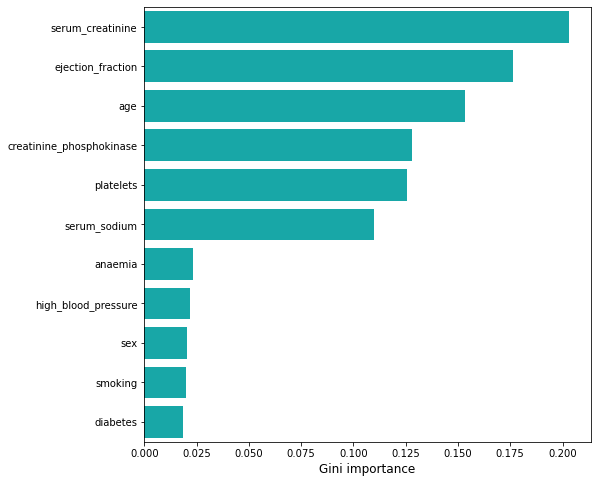

In [32]:
plt.figure(figsize=(8, 8), )
ax = sns.barplot(x=list(imp_dict), y=list(imp_dict.values()), color='c')
ax.set_xlabel('Gini importance', fontsize='large') ;

As we can see on the plot, features are ranked from the most important to least important.

This method shows us that 3 the most important features are ['serum_creatinine', 'ejection_fraction', 'age'], we already know this, they appeared in top-3 in every our test. 

The 4th feature this time appeared to be 'creatinine_phosphokinase', none of statistical tests we did before, showed this feature as significant.

### Results
To sum up, based on all our tests there always were 3 features, that show the most significant impact on our target. We are going to drop all the rest of the columns, and try to make prediction only with this 3 features

# 2. Feature selection

In [19]:
# drop the columns we don't need
cols_to_drop = ['anaemia', 'creatinine_phosphokinase', 'diabetes', 'high_blood_pressure', 'platelets', 'serum_sodium',
                'sex', 'smoking']
df.drop(cols_to_drop, axis=1, inplace=True)

In [20]:
df.head()

,age,ejection_fraction,serum_creatinine,DEATH_EVENT
0,75,20,1.9,1
1,55,38,1.1,1
2,65,20,1.3,1
3,50,20,1.9,1
4,65,20,2.7,1


Before we'll start a train-test split and such things, let's check the correlation between our features. Because if some variables except target will have significant correlation with another ones, it may affect our prediction results negatively.

It's unlikely that we'll see something unexpected here, but just in case

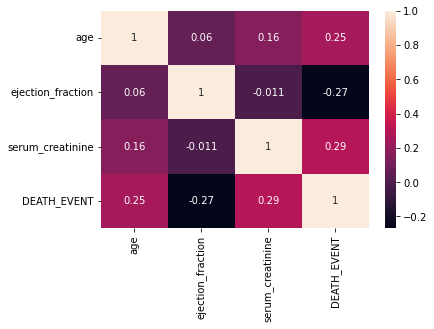

In [21]:
sns.heatmap(df.corr(), annot=True) ;

As we can see everything is fine, 'age', 'ejection_fraction' and 'serum_creatinine' doesn't show any correlation that can affect our results negatively. 

# 3. Model Training and Validation

In [23]:
X = df.drop('DEATH_EVENT', axis=1)
y = df['DEATH_EVENT']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)

Let's start validating our models. Some of them previously tuned a little bit with GridSearchCV for better perfomance 

C:\Users\Serge\AppData\Local\Temp/ipykernel_13020/896048458.py:61: RuntimeWarning: invalid value encountered in true_divide
  return ((1 + 0.5 ** 2) * (precision * recall)) / (0.5 ** 2 * precision + recall)


Test results for LogisticRegression:
------------------------------------------
F-05 using 5-times repeated 10-fold cross-validation = 0.6178008047927849
ROC AUC = 0.7932692307692307
PR AUC using 5-times repeated 10-fold cross-validation = 0.6797906416594433
Optimal threshold = 0.43578482740532326 with F-0.5 Score = 0.7377049180327868


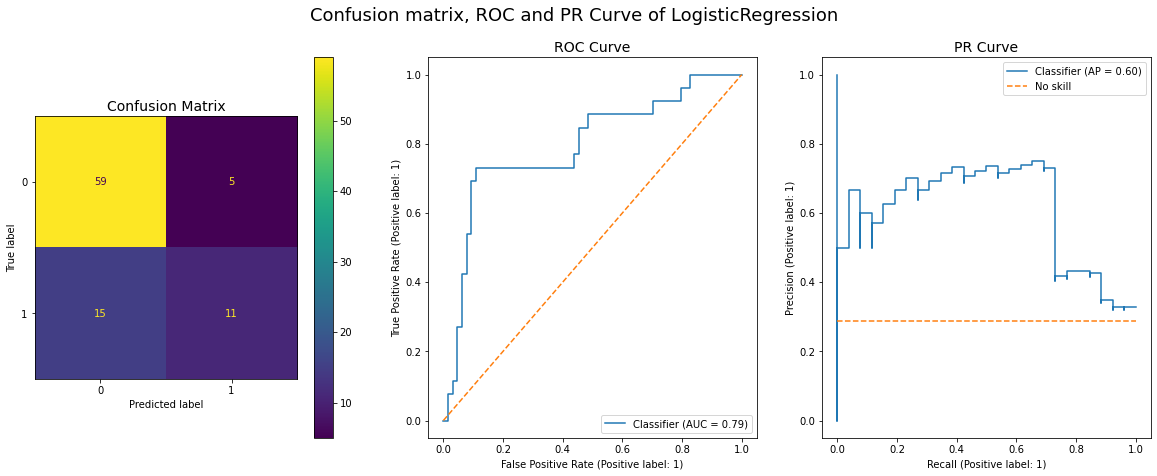

Test results for DecisionTreeClassifier:
------------------------------------------
F-05 using 5-times repeated 10-fold cross-validation = 0.4880610340447085
ROC AUC = 0.7803485576923077
PR AUC using 5-times repeated 10-fold cross-validation = 0.596365325530013
Optimal threshold = 0.4782608695652174 with F-0.5 Score = 0.6779661016949152


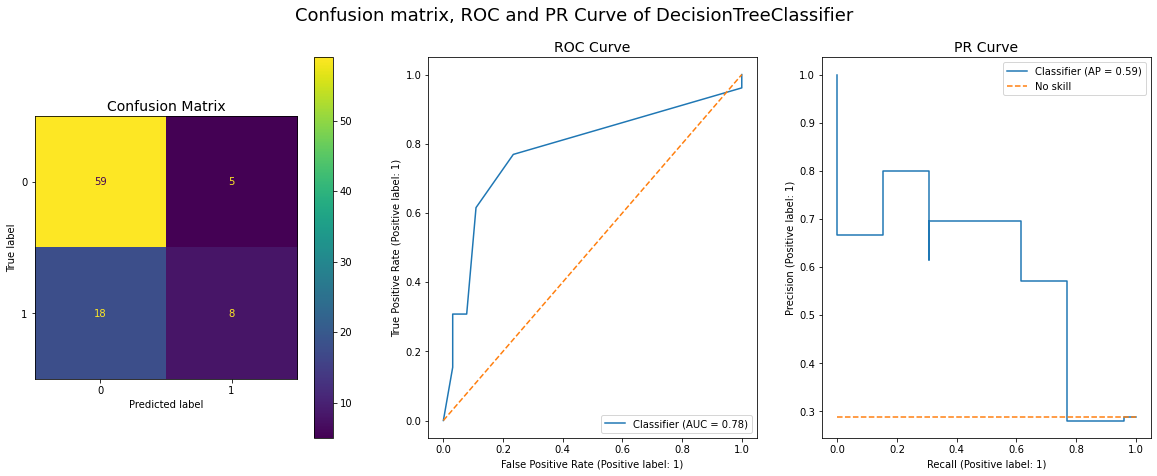

Test results for RandomForestClassifier:
------------------------------------------
F-05 using 5-times repeated 10-fold cross-validation = 0.5685937353573549
ROC AUC = 0.8260216346153846
PR AUC using 5-times repeated 10-fold cross-validation = 0.6570105637427003
Optimal threshold = 0.42 with F-0.5 Score = 0.6521739130434783


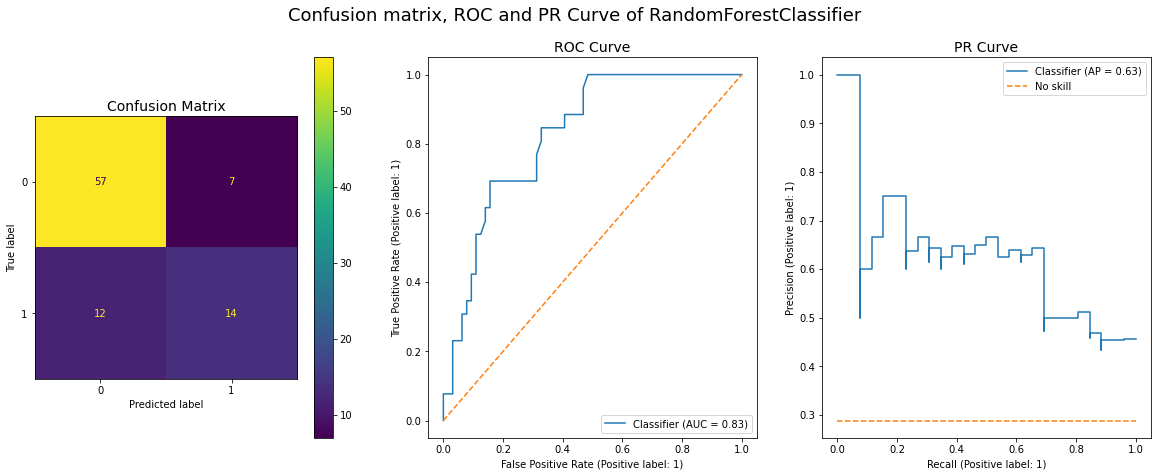

Test results for KNeighborsClassifier:
------------------------------------------
F-05 using 5-times repeated 10-fold cross-validation = 0.5155487532133323
ROC AUC = 0.7899639423076923
PR AUC using 5-times repeated 10-fold cross-validation = 0.6064105663551215
Optimal threshold = 0.5333333333333333 with F-0.5 Score = 0.6976744186046511


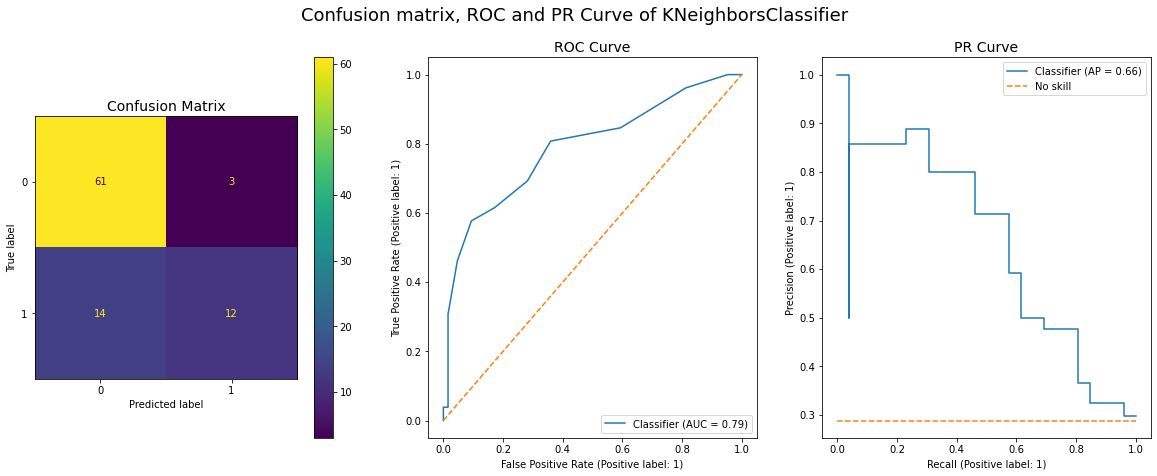

Test results for MultinomialNB:
------------------------------------------
F-05 using 5-times repeated 10-fold cross-validation = 0.5792071359544481
ROC AUC = 0.7830528846153847
PR AUC using 5-times repeated 10-fold cross-validation = 0.6631066131785393
Optimal threshold = 0.7175531263596217 with F-0.5 Score = 0.7653061224489796


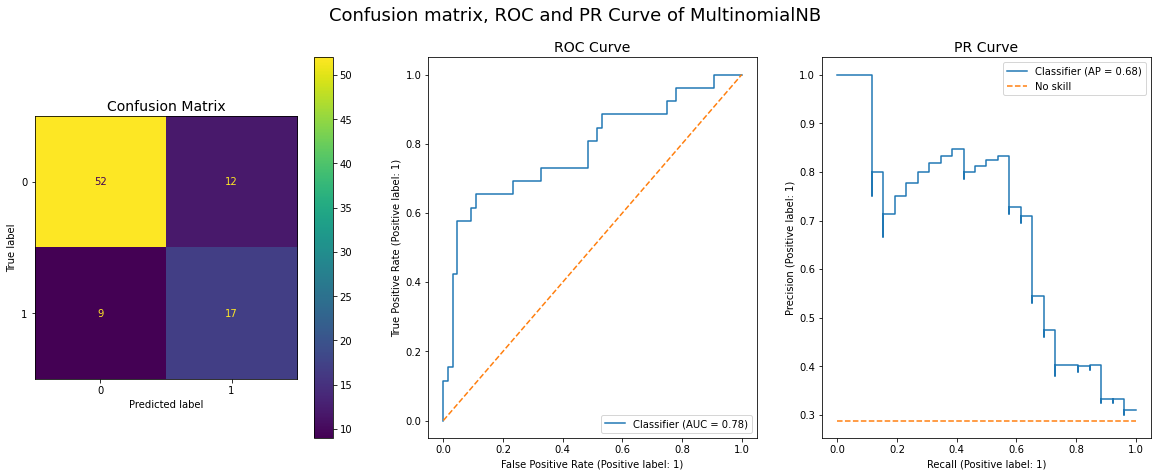

C:\Users\Serge\AppData\Local\Temp/ipykernel_13020/896048458.py:61: RuntimeWarning: invalid value encountered in true_divide
  return ((1 + 0.5 ** 2) * (precision * recall)) / (0.5 ** 2 * precision + recall)


Test results for SVC:
------------------------------------------
F-05 using 5-times repeated 10-fold cross-validation = 0.60083396286931
ROC AUC = 0.7950721153846153
PR AUC using 5-times repeated 10-fold cross-validation = 0.6776864049668109
Optimal threshold = 0.41500983566474386 with F-0.5 Score = 0.7075471698113207


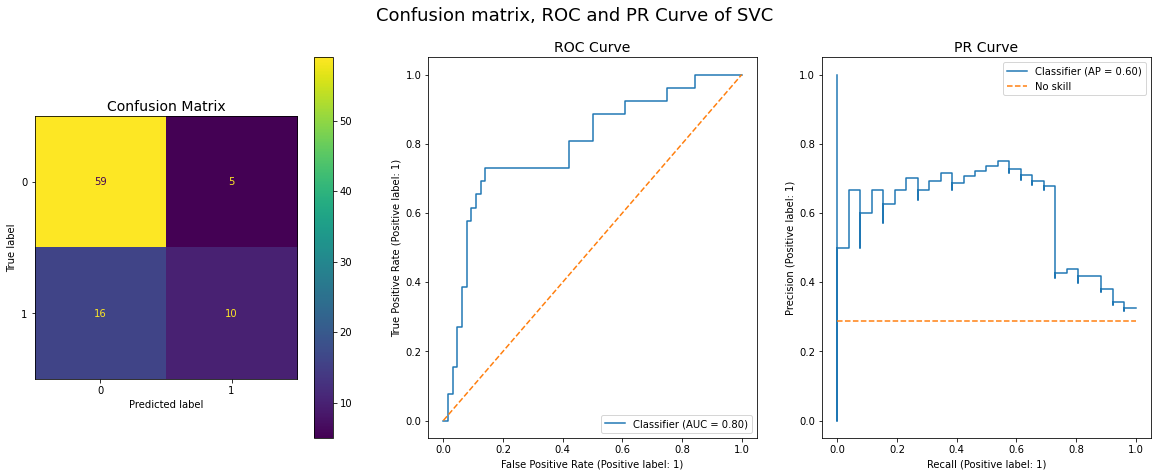

In [24]:
# list of our models
models = [LogisticRegression(penalty='l1', solver='liblinear'), DecisionTreeClassifier(max_depth=4), 
          RandomForestClassifier(max_features='sqrt', random_state=1), 
          KNeighborsClassifier(n_neighbors=15, metric='manhattan'), MultinomialNB(), 
          SVC(probability=True, kernel='linear', random_state=1)]

model_comparison = {} # we will store result of every model here, to create DataFrame then

# iterating over list of models, performing equal training and validation for each
for model in models:
    test_model = TestClassifier(model, y_test)
    test_model.fit(X_train, y_train)
    test_model.make_predictions(X_test)
    roc_auc, opt_threshold = test_model.test_results() # get results of a few tests
    f_score, pr_auc = test_model.test_with_cv() # results of test we decided to cross-validate
    print(f'Test results for {test_model.name()}:')
    print('------------------------------------------')
    print(f'F-05 using 5-times repeated 10-fold cross-validation = {f_score}')
    print(f'ROC AUC = {roc_auc}')
    print(f'PR AUC using 5-times repeated 10-fold cross-validation = {pr_auc}')
    print(f'Optimal threshold = {opt_threshold[0]} with F-0.5 Score = {opt_threshold[1]}')
    
    model_comparison.update({test_model.name():(f_score, roc_auc, pr_auc)}) # update our dictionary
    # plot test results
    test_model.plot_results();

In [25]:
# create data frame that will contain all our test results
result = df.from_dict(model_comparison, orient='index', columns=['F-0.5 Score', 'ROC AUC', 'PR AUC'])
# data frame with models sorted by 'PR AUC'
by_pr = result.sort_values(by='PR AUC', ascending=False)
by_pr.style.set_caption('Models Sorted by the PR AUC')

,F-0.5 Score,ROC AUC,PR AUC
LogisticRegression,0.617801,0.793269,0.679791
SVC,0.600834,0.795072,0.677686
MultinomialNB,0.579207,0.783053,0.663107
RandomForestClassifier,0.568594,0.826022,0.657011
KNeighborsClassifier,0.515549,0.789964,0.606411
DecisionTreeClassifier,0.488061,0.780349,0.596365


In [26]:
# data frame with models sorted by 'F-0.5'
by_f = result.sort_values(by='F-0.5 Score', ascending=False)
by_f.style.set_caption('Models Sorted by F-0.5 Score')

,F-0.5 Score,ROC AUC,PR AUC
LogisticRegression,0.617801,0.793269,0.679791
SVC,0.600834,0.795072,0.677686
MultinomialNB,0.579207,0.783053,0.663107
RandomForestClassifier,0.568594,0.826022,0.657011
KNeighborsClassifier,0.515549,0.789964,0.606411
DecisionTreeClassifier,0.488061,0.780349,0.596365


Let's look at the results of our models:
- Logistic Regression showed the best result out of all in both Average Precision and F-0.5 metric. After tuning it a little bit, i came up with this configuration fot the best results. Choosing the best model, we should consider this one.
- SVC showed almost similar results to Logistic Regression. While tuning, i discovered that this result can be achieved with 'linear' kernel, instead of default ('rbf').
- After a comparison between Gaussian Naive Bayes, Complement Naive Bayes and Multinomial Naive Bayes, the last one showed the best skill for our dateset. Also decent result in AP metric. In F-0.5 metric i expected better result for this model, cause naive Bayes is known as a decent classifier and a bad estimator. Think that our dataset doesn't really fit to this algorithm, because our data doesn't have Gaussian distribution or multinomially distributed data.
- For some reason Random Forest showed not that bright results. I expected more from this model.
- KNN showed quite low results compared to the models above. This is the best that i could get with tuning it a bit, specifically changing a metric from 'minkowski' to 'manhattan'. No wonder, because Manhattan distance is a good measure to use if the input variables are not similar in type. For example 'age' and 'serum_creatinine' in our case.
- As expected, Decision Tree showed the worst perfomance on our dataset. Setting 'max_depth' = 4 lead to better model skill, but didn't changed the 'global' situation at all.

Talking about ROC AUC, we can notice that for every model we can achieve higher results than for other 2 metrics. Fistly, we need to take into account that it's measured without cross-validation, meaning that results may be too optimistic in some cases. Secondly, higher scores could be obtained because of class disbalance. ROC Curve takes into account negative class predictions too, in our dataset we have ~70% negatives and ~30% positives. So this disbalance can result such scores

To sum up, Logistic Regression suites the most for our problem. Based on the cross-validation results, it proved to be the most stable one.